In [16]:
!pip install --upgrade matplotlib
!pip install -U seaborn
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2


In [1]:
from pathlib import Path
from turtle import position
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib as mpl
import seaborn as sns
sns.set(style="whitegrid")
import json
import numpy as np
from scipy.stats import chisquare

In [17]:
!pip show seaborn
!pip show matplotlib

Name: seaborn
Version: 0.12.2
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: /Users/andreasmotz/Developer/vod/med-chain/.venv/lib/python3.9/site-packages
Requires: matplotlib, numpy, pandas
Required-by: 
Name: matplotlib
Version: 3.7.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /Users/andreasmotz/Developer/vod/med-chain/.venv/lib/python3.9/site-packages
Requires: contourpy, cycler, fonttools, importlib-resources, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: seaborn


/Users/andreasmotz/Developer/vod/med-chain/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/andreasmotz/Developer/vod/med-chain/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/andreasmotz/Developer/vod/med-chain/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/andreasmotz/Developer/vod/med-chain/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


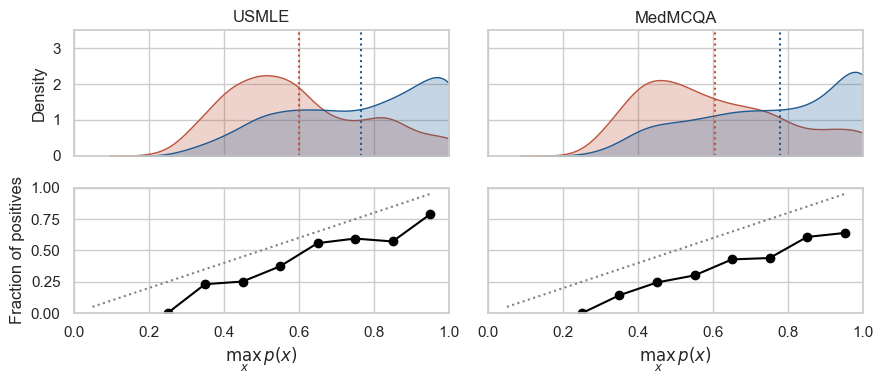

In [4]:
datadirs = {
    'USMLE': Path('/Users/andreasmotz/Research/meluxina/medical-reasoning/self-consistency/medqa/vicuna-33b/2023-07-06'),
    'MedMCQA': Path('/Users/andreasmotz/Research/meluxina/medical-reasoning/self-consistency/medmcqa/vicuna-33b/2023-07-06'),
}
n_samples = {
    'USMLE': 12,
    'MedMCQA': 12,
}

n_bins = 10
niceblue = "#1F5B93"
nicered = "#BE533B"
nicegreen = "#54AD72"

fig, axes = plt.subplots(2, 2, figsize=(9, 4), sharey="row", sharex="col")
for i, (dset, datadir) in enumerate(datadirs.items()):
    ax = axes[0, i]
    ax_cal = axes[1, i]
    with open(datadir / 'results.json') as f:
        data = json.load(f)
        probs = np.array(data["probs"])
        probs = probs[:, :n_samples[dset]]
        labels = data["labels"]
        preds = data["predictions"]

        def fn(p,l,t):
            p = np.array(p)
            return p.max()

        # get the max true and false probs
        prob_true = [fn(p,l,t) for p,l,t in zip(probs, labels, preds) if l==t]
        prob_false = [fn(p,l,t) for p,l,t in zip(probs, labels, preds) if l!=t]
    
        # plot the distribution
        sns.kdeplot(prob_false, color=nicered, label="Incorrect", fill=True, ax=ax)
        sns.kdeplot(prob_true, color=niceblue, label="Correct", fill=True, ax=ax)
        # sns.distplot(prob_false, color=nicered, label="Incorrect", hist=False, kde_kws={"fill": True}, ax=ax)
        # sns.distplot(prob_true, color=niceblue, label="Correct", hist=False, kde_kws={"fill": True}, ax=ax)
        ax.axvline(np.mean(prob_false), color=nicered, linestyle=":")
        ax.axvline(np.mean(prob_true), color=niceblue, linestyle=":")
        # ax.set_xlim(0.2, 1.2)
        ax.set_ylim(0, 3.5)
        ax.set_title(dset)
        if i == 2:
            ax.legend(loc="upper left") # loc="lower center")

        # plot the calibration curves
        prob_all = [(l==t, fn(p,l,t)) for p,l,t in zip(probs, labels, preds)]
        x = np.linspace(0, 1, n_bins+1)
        binsize = 1/n_bins
        y = np.zeros((n_bins,))
        for j in range(n_bins):
            bin_preds = [o for o,p in prob_all if x[j] <= p < x[j+1]]
            y[j] = np.mean(bin_preds)

        x = x[:-1] + binsize/2
        ax_cal.plot(x, y, color="black", marker="o", label="Calibration")
        ax_cal.plot(x, x, color="gray", linestyle=":",  label="Perfectly calibrated")
        ax_cal.set_ylim(0.0, 1)
        ax_cal.set_xlim(0.0,1)
        ax_cal.set_xlabel(r"$\max_{x}\, p(x)$")
        if i == 0:
            ax_cal.set_ylabel("Fraction of positives")
        if i == 2:
            ax_cal.legend(loc="upper left") # loc="lower center")



# plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.savefig("med-uncertainty-k40.png", dpi=600)
plt.show()

